In [19]:
import sys, os
sys.path.append(os.path.abspath(".."))
from utils.data_utils import load_clean_data

df = load_clean_data()
print(f"データ件数: {len(df)}")


⚡ クリーンデータをキャッシュからロード
データ件数: 67994


In [20]:
player_summary = (
    df.groupby("athlete_name")
      .agg(count=("date_", "count"), unique_days=("date_", lambda x: x.nunique()))
      .reset_index()
)

player_summary["density_ratio"] = player_summary["unique_days"] / (
    df.groupby("athlete_name")["date_"].transform(lambda x: (x.max() - x.min()).days + 1).unique()
)[0]

valid_players = player_summary.query("count >= 1000 and density_ratio >= 0.5")["athlete_name"]
df_valid = df[df["athlete_name"].isin(valid_players)].copy()

print(f"対象選手数: {df_valid['athlete_name'].nunique()}")


対象選手数: 24


In [21]:
# 日次平均・合計の指標を作成
daily_features = ["total_distance", "total_player_load", "mean_heart_rate"]
agg_funcs = {col: "mean" for col in daily_features}
agg_funcs.update({"session_duration_sec": "sum"})

df_daily = (
    df_valid.groupby(["athlete_name", "date_"])
    .agg(agg_funcs)
    .reset_index()
)

print(df_daily.head())


  athlete_name      date_  total_distance  total_player_load  mean_heart_rate  \
0   Asahi YADA 2024-01-12     1006.363205         114.695892        98.472747   
1   Asahi YADA 2024-01-13      859.911758         101.572553       127.201588   
2   Asahi YADA 2024-01-18      586.916458          72.913979        94.724526   
3   Asahi YADA 2024-01-19     1012.365682         121.149218        81.834778   
4   Asahi YADA 2024-01-20     4119.961430         475.533660        77.995880   

   session_duration_sec  
0                4034.0  
1                3590.0  
2                6642.0  
3                5308.0  
4                1823.0  


In [22]:
# %% ----------------------------------------
# 推奨セットアップ：ACWR（EWMA版）＋EWMAトレンド指標
# -------------------------------------------

import pandas as pd

# --- EWMA-ACWR計算関数 ---
def compute_acwr_ewma(series, acute_span=7, chronic_span=28):
    """EWMAを使ったACWR（急性／慢性比）を計算"""
    acute = series.ewm(span=acute_span, adjust=False).mean()
    chronic = series.ewm(span=chronic_span, adjust=False).mean()
    return acute / chronic


# -------------------------------------------
# Distance（活動量系）指標
# -------------------------------------------

# EWMA-ACWR (距離ベース)
df_daily["ACWR_EWMA_distance"] = (
    df_daily.groupby("athlete_name")["total_distance"]
    .transform(lambda s: compute_acwr_ewma(s, acute_span=7, chronic_span=28))
)

# EWMAトレンド（距離）
df_daily["EWMA7_distance"] = df_daily.groupby("athlete_name")["total_distance"].transform(
    lambda s: s.ewm(span=7, adjust=False).mean()
)
df_daily["EWMA28_distance"] = df_daily.groupby("athlete_name")["total_distance"].transform(
    lambda s: s.ewm(span=28, adjust=False).mean()
)


# -------------------------------------------
# Load（身体負荷系）指標
# -------------------------------------------

# EWMA-ACWR (負荷ベース)
df_daily["ACWR_EWMA_load"] = (
    df_daily.groupby("athlete_name")["total_player_load"]
    .transform(lambda s: compute_acwr_ewma(s, acute_span=7, chronic_span=28))
)

# EWMAトレンド（負荷）
df_daily["EWMA7_load"] = df_daily.groupby("athlete_name")["total_player_load"].transform(
    lambda s: s.ewm(span=7, adjust=False).mean()
)
df_daily["EWMA28_load"] = df_daily.groupby("athlete_name")["total_player_load"].transform(
    lambda s: s.ewm(span=28, adjust=False).mean()
)


# -------------------------------------------
# （オプション）比率・差分指標も生成可能
# -------------------------------------------

# 負荷トレンド比（短期／長期のバランス）
df_daily["EWMA_ratio_load"] = df_daily["EWMA7_load"] / df_daily["EWMA28_load"]

# 活動量トレンド比（短期／長期のバランス）
df_daily["EWMA_ratio_distance"] = df_daily["EWMA7_distance"] / df_daily["EWMA28_distance"]

# 確認
print("✅ 新しい特徴量を追加しました！")
print(df_daily.filter(regex="ACWR|EWMA").head())


✅ 新しい特徴量を追加しました！
   ACWR_EWMA_distance  EWMA7_distance  EWMA28_distance  ACWR_EWMA_load  \
0            1.000000     1006.363205      1006.363205        1.000000   
1            0.973388      969.750343       996.263105        0.979122   
2            0.902906      874.041872       968.032302        0.917259   
3            0.935673      908.622824       971.089776        0.954833   
4            1.440314     1711.457476      1188.253339        1.453969   

   EWMA7_load  EWMA28_load  EWMA_ratio_load  EWMA_ratio_distance  
0  114.695892   114.695892         1.000000             1.000000  
1  111.415057   113.790835         0.979122             0.973388  
2  101.789788   110.971741         0.917259             0.902906  
3  106.629646   111.673636         0.954833             0.935673  
4  198.855649   136.767431         1.453969             1.440314  


In [29]:
df_daily[["athlete_name", "date_", "ACWR_EWMA_distance", "ACWR_EWMA_load", 
          "EWMA_ratio_distance", "EWMA_ratio_load"]].head(10)


,athlete_name,date_,ACWR_EWMA_distance,ACWR_EWMA_load,EWMA_ratio_distance,EWMA_ratio_load
0,Asahi YADA,2024-01-12,1.000000,1.000000,1.000000,1.000000
1,Asahi YADA,2024-01-13,0.973388,0.979122,0.973388,0.979122
2,Asahi YADA,2024-01-18,0.902906,0.917259,0.902906,0.917259
3,Asahi YADA,2024-01-19,0.935673,0.954833,0.935673,0.954833
4,Asahi YADA,2024-01-20,1.440314,1.453969,1.440314,1.453969
5,Asahi YADA,2024-01-21,1.326771,1.334922,1.326771,1.334922
6,Asahi YADA,2024-01-22,1.173241,1.163069,1.173241,1.163069
7,Asahi YADA,2024-01-23,1.239281,1.225952,1.239281,1.225952
8,Asahi YADA,2024-01-26,1.154592,1.129633,1.154592,1.129633
9,Asahi YADA,2024-01-27,1.028528,1.017577,1.028528,1.017577


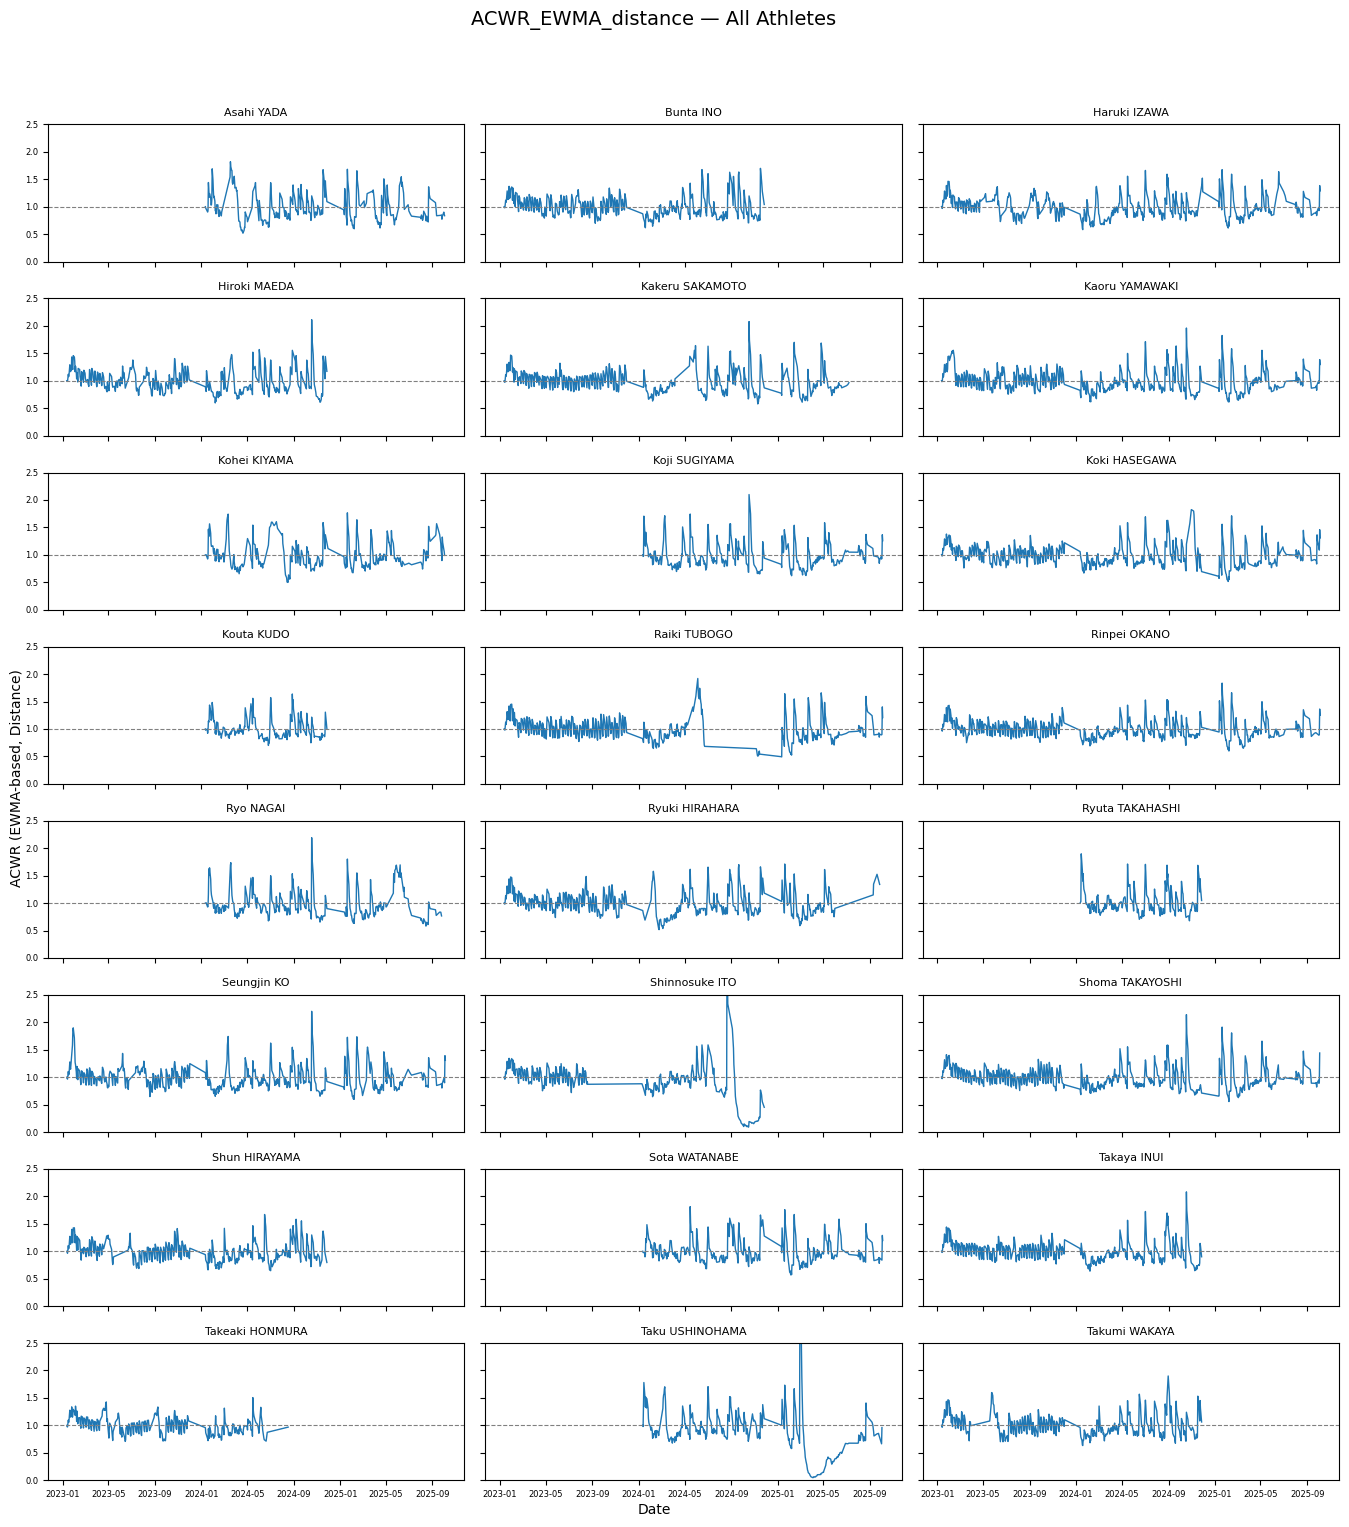

In [30]:
# %%
import matplotlib.pyplot as plt
import math

# ユニークな選手名を取得
players = df_daily["athlete_name"].unique()
num_players = len(players)

# グリッドレイアウト設定（例：横3列）
cols = 3
rows = math.ceil(num_players / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 2.0), sharex=True, sharey=True)
axes = axes.flatten()

# 各選手ごとにプロット
for i, player in enumerate(players):
    ax = axes[i]
    sub = df_daily[df_daily["athlete_name"] == player]
    ax.plot(sub["date_"], sub["ACWR_EWMA_distance"], color="tab:blue", linewidth=1)
    ax.axhline(1.0, color="gray", linestyle="--", linewidth=0.8)
    ax.set_title(player, fontsize=8)
    ax.set_ylim(0, 2.5)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

# 余白グラフ（空の枠）を非表示
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("ACWR_EWMA_distance — All Athletes", fontsize=14)
fig.text(0.5, 0.04, "Date", ha="center")
fig.text(0.04, 0.5, "ACWR (EWMA-based, Distance)", va="center", rotation="vertical")

plt.tight_layout(rect=[0.04, 0.04, 1, 0.95])
plt.show()
